## Load necessary libraries and prepare dataset

In [ ]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from datasets import load_dataset

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import gensim
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from gensim import corpora, models, similarities, downloader

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(42)

import numpy as np
np.random.seed(42)

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
transformation = lambda s: " ".join([lemmatizer.lemmatize(word) for word in re.sub('[\W\d]+', ' ', s).lower().split() if word not in stop_words])

# read /fp/projects01/ec30/IN5550/obligatories/1/arxiv_train.csv.gz
dataset = pd.read_csv("/fp/projects01/ec30/IN5550/obligatories/1/arxiv_train.csv.gz", compression="gzip")
dataset['abstract_org'] = dataset['abstract'] #backup
dataset['abstract'] = dataset['abstract'].apply(transformation)

[nltk_data] Downloading package wordnet to /fp/homes01/u01/ec-
[nltk_data]     sushantg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /fp/homes01/u01/ec-
[nltk_data]     sushantg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Train custom word embedding model

In [ ]:
print("Available pre-trained corpora:", list(downloader.info()['corpora'].keys()))
print([folder for folder in os.listdir('/fp/projects01/ec30/corpora')])

Available pre-trained corpora: ['semeval-2016-2017-task3-subtaskBC', 'semeval-2016-2017-task3-subtaskA-unannotated', 'patent-2017', 'quora-duplicate-questions', 'wiki-english-20171001', 'text8', 'fake-news', '20-newsgroups', '__testing_matrix-synopsis', '__testing_multipart-matrix-synopsis']
['bnc', 'norwegian-alpaca', 'databricks-dolly-15k', 'enwiki', 'ontonotes-release-5.0', 'OpenAssistant', 'dia_nor']


In [ ]:
# dataset_arxiv_hf_df = pd.DataFrame({'abstract': load_dataset("gfissore/arxiv-abstracts-2021")["train"]['abstract']})
# dataset_arxiv_hf_df['abstract'] = dataset_arxiv_hf_df['abstract'].apply(transformation)
# concatenated_df = pd.concat([pd.DataFrame({'abstract': dataset['abstract'].values}), dataset_arxiv_hf_df], ignore_index=True)
# concatenated_df_ = concatenated_df.dropna(subset=['abstract'])
# concatenated_df_.to_csv('corpus.csv', index=False)
# corpus_to_train = concatenated_df['abstract']

# corpus_to_train = pd.read_csv('corpus.csv').dropna()['abstract']

In [ ]:
# #number of abstracts in corpus_to_train : 2,079,484, from dataset_arxiv_hf: 2M  from our dataset['abstract']: 80K
# print("Total number of tokens:", corpus_to_train.apply(lambda x: len(x.split())).sum()) # 179,355,863
# print("Number of unique tokens:", len(set(" ".join(corpus_to_train).split()))) # 471,322

In [ ]:
class LossLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.losses = []
    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch > 0:
            current_loss = loss - self.prev_loss
            self.losses.append(current_loss)
            print(f'Epoch {self.epoch}: Loss: {current_loss}')
        else:
            self.losses.append(loss)
            print(f'Epoch {self.epoch}: Loss: {loss}')
        self.prev_loss = loss
        self.epoch += 1

In [ ]:
# corpus_gn = corpus_to_train.apply(lambda x: x.split()).values[:10]
# model_gn = Word2Vec(vector_size=300, window=5, min_count=5, workers=60, epochs=20, sg=1)
# model_gn.build_vocab(corpus_iterable=corpus_gn)
# print('\n'.join([f"{member}: {size / (1024 * 1024):.2f} MB" for member, size in model_gn.estimate_memory().items()]))

[28249280.0, 16752928.0, 14551592.0, 8131464.0, 1066216.0, 1044392.0, 1033128.0, 1092200.0, 1011840.0, 979288.0, 932632.0, 941664.0, 908408.0, 856944.0, 844160.0, 841848.0, 884648.0, 811488.0, 818648.0, 762072.0]


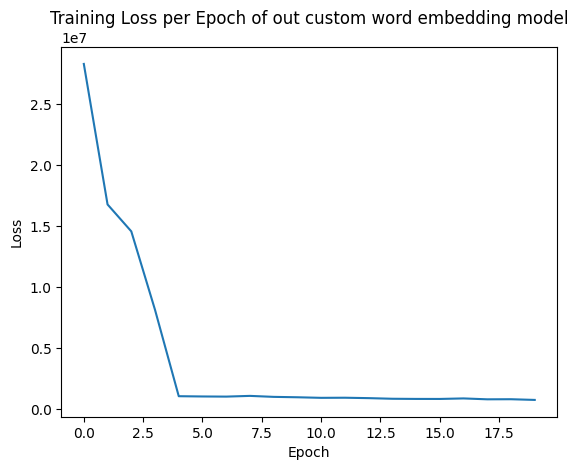

(34, 300)

In [ ]:
# loss_logger = LossLogger()
# model_gn.train(corpus_gn, total_examples=len(corpus_gn), epochs=model_gn.epochs, compute_loss=True, callbacks=[loss_logger])
# loss_logger.losses = [28249280.0, 16752928.0, 14551592.0, 8131464.0, 1066216.0, 1044392.0, 1033128.0, 1092200.0, 1011840.0, 979288.0, 932632.0, 941664.0, 908408.0, 856944.0, 844160.0, 841848.0, 884648.0, 811488.0, 818648.0, 762072.0]
# print(loss_logger.losses)
# plt.plot(loss_logger.losses)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss per Epoch of out custom word embedding model')
# plt.show()
# model_gn.wv.vectors.shape #model.wv.index_to_key

In [ ]:
# model.save("xword2vec_300_5_5_20_1")

## Choose and load Pretrained models

In [ ]:
print("Available pre-trained modules:", list(downloader.info()['models'].keys()))

Available pre-trained modules: ['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
model_list = {
            "glove-twitter-25": downloader.load("glove-twitter-25"),
            "word2vec-google-news-300": downloader.load("word2vec-google-news-300"),
            "glove-wiki-gigaword-300": downloader.load("glove-wiki-gigaword-300"),
            "fasttext-wiki-news-subwords-300": downloader.load("fasttext-wiki-news-subwords-300"),
        }

In [ ]:
# all_words = [word for abstract in dataset['abstract'] for word in abstract.split()]
# unique_words = set(all_words)
# print("Total Words in our corpus:", len(all_words))
# print("Unique words in our corpus:", len(unique_words))

# for model_name in ['glove-twitter-25', 'word2vec-google-news-300', 'glove-wiki-gigaword-300', 'fasttext-wiki-news-subwords-300']:
#     word_model = model_list[model_name]
#     words_in_model = [word for word in all_words if word in word_model]
#     unique_words_in_model =  set(words_in_model)
#     print("\n>> {} Model loaded.".format(model_name))
#     print(f"Unique words from our corpus present in model: {len(unique_words_in_model)} ({(len(unique_words_in_model) / len(unique_words)) * 100:.2f}%)")
#     print(f"Total words from our corpus present in model: {len(words_in_model)} ({(len(words_in_model) / len(all_words)) * 100:.2f}%)")
#     print("Total number of vocabulary words in model:", len(word_model.index_to_key))

- Total Words in our corpus: 7950716
-  Unique words in our corpus: 85756

**GloVe Twitter 25 Model:**
- Unique words from our corpus present in model: 36,883 (43.01%)
- Total words from our corpus present in model: 7,360,299 (92.57%)
- Total number of vocabulary words in model: 1,193,514

**Word2Vec Google News 300 Model:**
- Unique words from our corpus present in model: 34,500 (40.23%)
- Total words from our corpus present in model: 7,501,847 (94.35%)
- Total number of vocabulary words in model: 3,000,000

**GloVe Wiki Gigaword 300 Model:**
- Unique words from our corpus present in model: 44,642 (52.06%)
- Total words from our corpus present in model: 7,694,945 (96.78%)
- Total number of vocabulary words in model: 400,000

**FastText Wiki News Subwords 300 Model:**
- Unique words from our corpus present in model: 40,637 (47.39%)
- Total words from our corpus present in model: 7,664,711 (96.40%)
- Total number of vocabulary words in model: 999,999


## Define models and dataloader

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['abstract'].values, dataset['label'].values, test_size=0.3, random_state=42, stratify=dataset['label'])
id2label = dict(enumerate(dataset['label'].unique()))
label2id = {v: k for k, v in id2label.items()}

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, sentences, labels, word_emb_model, unk_index):
        self.unk_index = unk_index
        self.tokens = [
            [
                word_emb_model.get(token.lower(), self.unk_index)
                for token in sentence.split()
            ]
            for sentence in sentences
        ]

        unk_tokens = sum(token == self.unk_index for document in self.tokens for token in document)
        n_tokens = sum(len(document) for document in self.tokens)
        print(f"Percentage of unknown tokens: {unk_tokens / n_tokens * 100.0:.2f}%")
        self.label = list(labels)


    def __getitem__(self, index):
        current_tokens = self.tokens[index]
        current_label = self.label[index]

        x = torch.LongTensor(current_tokens)
        y = torch.LongTensor([label2id[current_label]])
        return x, y

    def __len__(self):
        return len(self.tokens)


class CollateFunctor:
    def __init__(self, padding_index: int, max_length: int):
        self.padding_index = padding_index
        self.max_length = max_length

    # Gets a list of outputs from the dataset and outputs tensors
    def __call__(self, samples):
        input_ids = [x for x, _ in samples]
        labels = [y for _, y in samples]

        input_ids_padded = torch.nn.utils.rnn.pad_sequence(
            input_ids,
            batch_first = True,
            padding_value=self.padding_index,
        )
        input_ids_padded = input_ids_padded[:, :self.max_length]
        return input_ids_padded, torch.LongTensor(labels)

num_classes = len(id2label)

In [ ]:
def getWordWV(oov_handler="mean", model_name="word2vec_300_5_5_20_1"):
    if "custom_" in model_name:
        word_model = gensim.models.KeyedVectors.load(model_name.replace("custom_", "")).wv
    else:
        word_model = model_list[model_name]

    if oov_handler =="mean":
        word_model["[UNK]"] = torch.tensor(word_model.vectors).mean(dim=0).numpy() #average
    elif oov_handler =="random":
        word_model["[UNK]"] = np.random.uniform(low=-0.3, high=0.3, size=(word_model.vector_size,)) # random''
    else:
        word_model["[UNK]"] = torch.zeros(word_model.vector_size).numpy()

    word_model["[PAD]"] = torch.zeros(word_model.vector_size).numpy()
    return word_model



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TextClassifier(nn.Module):
    def __init__(self, layer_map=[128], dropout_rate=0.5, merge_operation='average', embedding_type='glove-twitter-25', oov_handler="mean", freeze_emb=True):
        super().__init__()
        embedding_wv = getWordWV(oov_handler, embedding_type) # return model.wv
        self.key_to_index = embedding_wv.key_to_index
        self.pad_index = embedding_wv.get_index("[PAD]")
        self.unk_index = embedding_wv.get_index("[UNK]")
        self.embedding_dim = embedding_wv.vector_size
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_wv.vectors),  freeze=freeze_emb)
        self.merge_operation = merge_operation
        self.fc_layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        self.id2label = id2label
        prev_layer_size = self.embedding_dim  # Adjusted to use embedding_dim as input size
        if self.merge_operation == "concat":
            prev_layer_size= prev_layer_size *3
        for size in layer_map:
            self.fc_layers.append(nn.Linear(prev_layer_size, size))
            prev_layer_size = size
        self.fc_out = nn.Linear(prev_layer_size, len(label2id))

    def forward(self, x):
        # x is assumed to be a batch of sentences with token indices
        embedded = self.embedding(x)  # Convert token indices to embeddings

        if self.merge_operation == 'average':
            sentence_lengths = (x != 0).sum(dim=1, keepdim=True)  # Assuming padding index is 0
            sentence_embeddings = embedded.sum(dim=1) / sentence_lengths

        elif self.merge_operation == 'sum':
            sentence_embeddings = embedded.sum(dim=1)

        elif self.merge_operation == 'max':
            sentence_embeddings, _ = embedded.max(dim=1)

        elif self.merge_operation == 'concat':
            # Assuming we want to concatenate average, sum, and max embeddings for a richer representation
            avg_embeddings = embedded.sum(dim=1) / (x != 0).sum(dim=1, keepdim=True)
            sum_embeddings = embedded.sum(dim=1)
            max_embeddings, _ = embedded.max(dim=1)
            sentence_embeddings = torch.cat((avg_embeddings, sum_embeddings, max_embeddings), dim=1)

        else:
            raise ValueError(f"Unsupported merge_operation: {self.merge_operation}")


        for layer in self.fc_layers:
            sentence_embeddings = F.relu(layer(sentence_embeddings))
            sentence_embeddings = self.dropout(sentence_embeddings)
        output = self.fc_out(sentence_embeddings)
        return output


In [ ]:
def evaluate(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.squeeze(1).to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    print(classification_report(all_labels, all_preds, target_names=list(id2label.values()), zero_division=0))


def plot_loss_curve(train_loss, val_loss):
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def train(model, criterion, _optimizer, train_loader, val_loader, epochs, verbose):
    model.to(device)
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.squeeze(1).to(device), labels.to(device)

            _optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            _optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        running_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.squeeze(1).to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate validation loss
        val_loss.append(running_loss / len(val_loader))
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
        if verbose:
            print(f'Epoch {epoch+1}, Train Loss: {train_loss[-1]:.6f}, Val. Loss: {val_loss[-1]:.6f}, F1: {f1:.6f}')
                        # Precision: {precision:.6f}, Recall: {recall:.6f},
        else:
            print(f'{f1*100:.2f},', end=" ")
    print("")
    return train_loss, val_loss

In [ ]:
max_length = 280 #260
criterion = nn.CrossEntropyLoss()
def train_evaluate(merge_operation, embedding_type,  oov_handler, freeze_emb,
                   model_layer_map, lr_, epochs_, batch_size_, verbose_=True): # custom model can also be passes
    print("Model with merge_operation = {}, embedding_type: {}, oov_handle: {}, freeze_emb: {}, model_layer_map: {}, lr: {}, batch_size: {}".format(merge_operation, embedding_type, oov_handler, freeze_emb, model_layer_map, lr_, batch_size_))

    model=TextClassifier(layer_map=model_layer_map, merge_operation=merge_operation, embedding_type=embedding_type, oov_handler=oov_handler, freeze_emb=freeze_emb,)
    print("Trainable paramaters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

    train_loader = DataLoader(CustomDataset(X_train, y_train, model.key_to_index, model.unk_index), batch_size=batch_size_, shuffle=True, drop_last=False,
                                 collate_fn= CollateFunctor(model.pad_index, max_length))
    test_loader = DataLoader(CustomDataset(X_test, y_test, model.key_to_index, model.unk_index), batch_size=batch_size_, shuffle=False, drop_last=False,
                                collate_fn= CollateFunctor(model.pad_index, max_length))

    print(model)
    optimizer= torch.optim.Adam(model.parameters(), lr=lr_)
    train_loss, val_loss = train(model, criterion, optimizer, train_loader, test_loader, epochs=epochs_, verbose=verbose_)
    evaluate(model, test_loader)
    return model, train_loss, val_loss

# Experiments

##### Arguments for experimentations
- merge_operation' average, sum, max, conact
-  embedding_type (pretrained) = "glove-twitter-25", "word2vec-google-news-300", "glove-wiki-gigaword-300", "fasttext-wiki-news-subwords-300"
-  embedding_type (our models) = "custom_word2vec_100_5_5_10_1", "custom_word2vec_300_5_5_20_1", "custom_fasttext_100_5_5_10_1"
- oov_handler= mean, random, zero
- freeze_emb= True, False

In [ ]:
lr=0.01; batch_size=10000; epochs=100

## A: Different ways of merging the sequence of embeddings into a fixed-size

Experiment A-1: merge_operation-average
Model with merge_operation = average, embedding_type: custom_word2vec_300_5_5_20_1, oov_handle: zero, freeze_emb: True, model_layer_map: [64], lr: 0.01, batch_size: 10000
Trainable paramaters:  19914
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (fc_layers): ModuleList(
    (0): Linear(in_features=300, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_out): Linear(in_features=64, out_features=10, bias=True)
)
48.17, 60.87, 68.18, 69.39, 71.78, 74.40, 75.80, 76.97, 78.39, 79.08, 79.89, 80.21, 80.53, 80.99, 81.06, 81.31, 81.52, 81.62, 81.96, 82.06, 82.15, 82.38, 82.36, 82.52, 82.75, 82.70, 82.82, 82.87, 83.00, 83.17, 83.10, 83.35, 83.24, 83.46, 83.29, 83.41, 83.56, 83.49, 83.67, 83.62, 83.75, 83.81, 83.89, 83.71, 83.85, 84.03, 84.06, 84.08, 83.98, 84.09, 84.18, 84.16, 84.09, 84.19, 84.11, 84.25, 84.21, 84.33, 84.29, 84.19, 84.27, 84.26, 

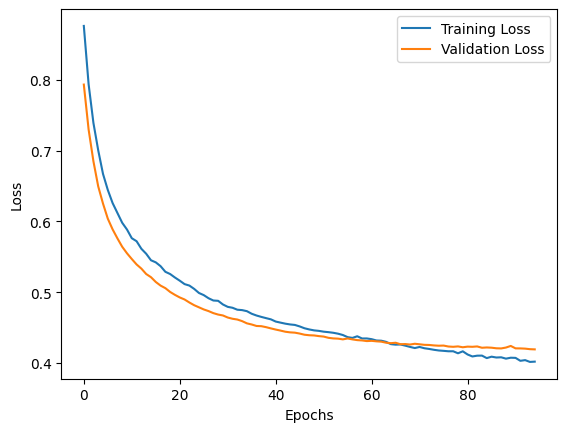

In [ ]:
print("Experiment A-1: merge_operation-average")
_, train_loss, val_loss = train_evaluate(merge_operation='average', embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                   model_layer_map=[64], lr_=lr, epochs_=epochs, batch_size_=batch_size, verbose_=False)
plot_loss_curve(train_loss[5:], val_loss[5:])

Experiment A-2: merge_operation-max
Model with merge_operation = max, embedding_type: custom_word2vec_300_5_5_20_1, oov_handle: zero, freeze_emb: True, model_layer_map: [512], lr: 0.01, batch_size: 10000
Trainable paramaters:  159242
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (fc_layers): ModuleList(
    (0): Linear(in_features=300, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_out): Linear(in_features=512, out_features=10, bias=True)
)
2.02, 16.37, 32.65, 44.61, 50.41, 58.16, 64.30, 65.26, 66.60, 69.72, 70.89, 72.83, 73.41, 73.97, 74.81, 75.30, 75.92, 75.80, 76.31, 76.79, 76.65, 76.51, 76.93, 76.15, 76.93, 77.33, 77.30, 77.44, 77.62, 77.61, 77.79, 77.81, 77.81, 77.60, 77.79, 78.02, 77.96, 78.15, 77.73, 77.62, 78.13, 77.98, 77.95, 78.16, 78.06, 77.71, 78.17, 78.03, 77.98, 78.31, 77.89, 78.07, 78.28, 78.37, 78.02, 78.13, 78.39, 78.36, 78.44, 78.52, 77.97, 78.06, 78.13

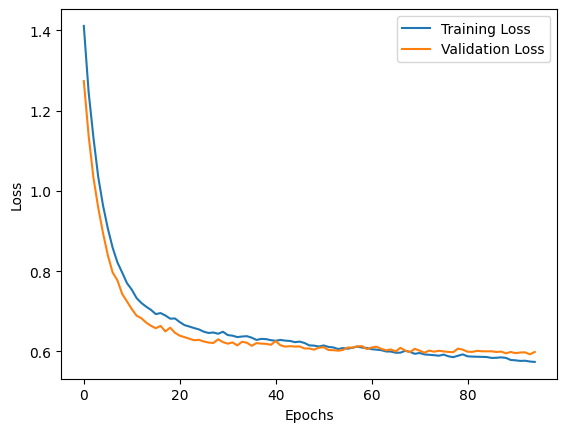

In [ ]:
print("Experiment A-2: merge_operation-max")
_, train_loss, val_loss = train_evaluate(merge_operation='max', embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                   model_layer_map=[512], lr_=lr, epochs_=epochs, batch_size_=batch_size, verbose_=False)
plot_loss_curve(train_loss[5:], val_loss[5:])

Experiment A-3: merge_operation-sum
Model with merge_operation = sum, embedding_type: custom_word2vec_300_5_5_20_1, oov_handle: zero, freeze_emb: True, model_layer_map: [512], lr: 0.01, batch_size: 10000
Trainable paramaters:  159242
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (fc_layers): ModuleList(
    (0): Linear(in_features=300, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_out): Linear(in_features=512, out_features=10, bias=True)
)
25.11, 32.47, 44.40, 60.83, 72.51, 75.46, 77.44, 79.04, 79.99, 80.88, 81.06, 81.29, 81.70, 81.86, 82.03, 82.15, 82.20, 82.19, 82.48, 82.61, 82.61, 82.64, 82.77, 82.83, 82.97, 82.86, 83.11, 83.08, 83.25, 83.16, 83.26, 83.39, 83.36, 83.46, 83.24, 83.57, 83.56, 83.55, 83.40, 83.51, 83.50, 83.35, 83.77, 83.72, 83.65, 83.70, 83.88, 83.79, 83.61, 83.49, 83.82, 83.70, 83.87, 83.72, 83.71, 84.02, 83.80, 83.64, 83.76, 83.32, 83.82, 83.81, 83.7

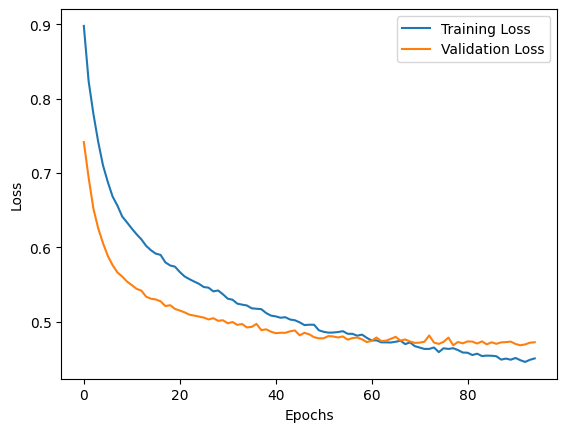

In [ ]:
print("Experiment A-3: merge_operation-sum")
_, train_loss, val_loss = train_evaluate(merge_operation='sum', embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                   model_layer_map=[512], lr_=lr, epochs_=epochs, batch_size_=batch_size, verbose_=False)
plot_loss_curve(train_loss[5:], val_loss[5:])

Experiment A-4: merge_operation-concat
Model with merge_operation = concat, embedding_type: custom_word2vec_300_5_5_20_1, oov_handle: zero, freeze_emb: True, model_layer_map: [512], lr: 0.01, batch_size: 10000
Trainable paramaters:  466442
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (fc_layers): ModuleList(
    (0): Linear(in_features=900, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_out): Linear(in_features=512, out_features=10, bias=True)
)
19.44, 32.62, 46.98, 58.75, 69.40, 72.86, 74.20, 76.09, 77.10, 77.72, 78.65, 79.19, 79.73, 80.18, 80.55, 80.62, 81.42, 81.67, 81.81, 82.10, 82.13, 82.21, 82.37, 82.18, 82.13, 82.37, 82.68, 82.46, 82.30, 82.59, 82.60, 82.64, 82.67, 82.79, 82.54, 82.67, 82.36, 82.85, 82.90, 82.90, 83.05, 82.88, 83.13, 83.07, 83.08, 82.78, 83.02, 82.92, 82.89, 82.72, 83.12, 82.80, 83.14, 83.22, 83.08, 83.01, 83.04, 83.06, 82.76, 83.32, 83.25, 83.19

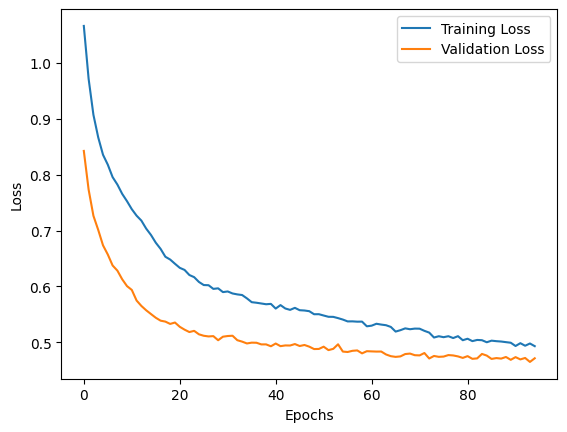

In [ ]:
print("Experiment A-4: merge_operation-concat")
_, train_loss, val_loss = train_evaluate(merge_operation='concat', embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=True,
                   model_layer_map=[512], lr_=lr, epochs_=epochs, batch_size_=batch_size, verbose_=False)
plot_loss_curve(train_loss[5:], val_loss[5:])

## B: Different ways of dealing with out-of-vocabulary words;

Experiment B-1: OOV handling-mean
Model with merge_operation = concat, embedding_type: glove-twitter-25, oov_handle: mean, freeze_emb: True, model_layer_map: [512], lr: 0.01, batch_size: 10000
Trainable paramaters:  44042
Percentage of unknown tokens: 7.42%
Percentage of unknown tokens: 7.44%
TextClassifier(
  (embedding): Embedding(1193516, 25)
  (fc_layers): ModuleList(
    (0): Linear(in_features=75, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_out): Linear(in_features=512, out_features=10, bias=True)
)
4.20, 12.01, 6.75, 11.53, 16.16, 22.33, 26.01, 29.72, 31.43, 34.28, 35.84, 36.59, 37.66, 37.98, 38.05, 40.60, 40.30, 40.80, 41.86, 42.46, 42.01, 43.30, 43.90, 44.56, 44.69, 45.40, 44.96, 45.80, 46.04, 46.17, 45.77, 46.54, 45.48, 46.49, 46.90, 46.75, 46.60, 47.23, 46.77, 46.97, 46.93, 47.55, 47.30, 47.24, 47.12, 47.92, 47.30, 47.07, 47.12, 47.74, 48.09, 47.39, 47.77, 47.70, 47.46, 46.90, 48.04, 47.88, 47.74, 48.00, 47.68, 48.28, 47.34, 48.24, 47.97

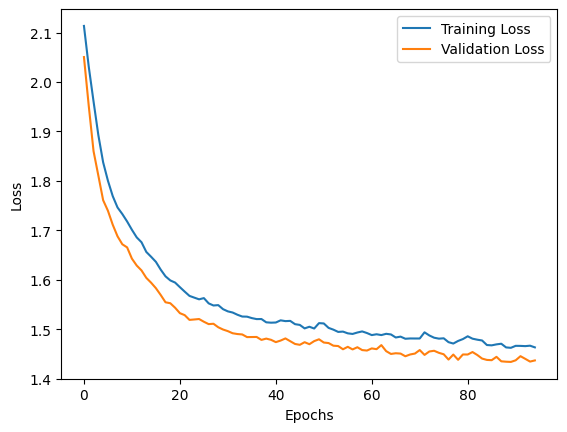

In [ ]:
print("Experiment B-1: OOV handling-mean")
_, train_loss, val_loss = train_evaluate(merge_operation='concat', embedding_type='glove-twitter-25', oov_handler="mean", freeze_emb=True,
                   model_layer_map=[512], lr_=lr, epochs_=epochs, batch_size_=batch_size, verbose_=False)
plot_loss_curve(train_loss[5:], val_loss[5:])

Experiment B-2: OOV handling-random
Model with merge_operation = concat, embedding_type: glove-twitter-25, oov_handle: random, freeze_emb: True, model_layer_map: [512], lr: 0.01, batch_size: 10000
Trainable paramaters:  44042
Percentage of unknown tokens: 7.42%
Percentage of unknown tokens: 7.44%
TextClassifier(
  (embedding): Embedding(1193516, 25)
  (fc_layers): ModuleList(
    (0): Linear(in_features=75, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_out): Linear(in_features=512, out_features=10, bias=True)
)
1.82, 5.02, 10.84, 12.14, 14.01, 21.05, 25.07, 30.01, 30.40, 34.28, 37.11, 38.61, 40.13, 41.65, 41.35, 42.85, 42.37, 43.39, 44.61, 44.66, 45.03, 45.34, 45.14, 45.73, 46.04, 46.07, 46.41, 46.63, 46.31, 46.74, 46.79, 47.10, 47.27, 47.44, 47.42, 47.87, 47.60, 46.60, 47.94, 47.93, 47.41, 47.61, 47.50, 47.61, 47.62, 47.29, 47.10, 48.25, 48.35, 47.95, 48.53, 48.32, 48.40, 47.85, 48.55, 48.31, 48.25, 48.49, 48.82, 48.95, 48.95, 47.78, 48.72, 48.34, 4

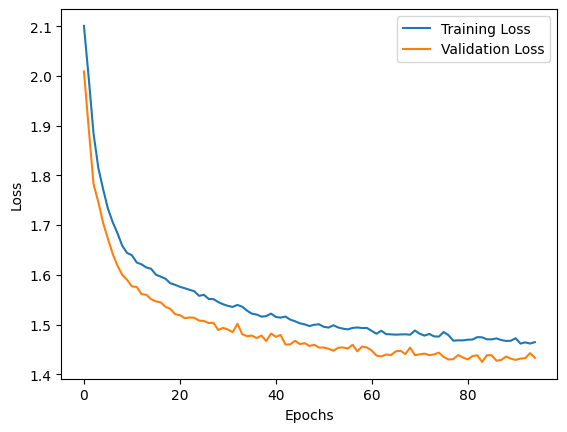

In [ ]:
print("Experiment B-2: OOV handling-random")
_, train_loss, val_loss = train_evaluate(merge_operation='concat', embedding_type='glove-twitter-25', oov_handler="random", freeze_emb=True,
                   model_layer_map=[512], lr_=lr, epochs_=epochs, batch_size_=batch_size, verbose_=False)
plot_loss_curve(train_loss[5:], val_loss[5:])

## C: Different pretrained embedding models

*   List item
*   List item



Experiment C-1: embedding_type-glove-twitter-25
Model with merge_operation = concat, embedding_type: glove-twitter-25, oov_handle: zero, freeze_emb: True, model_layer_map: [512], lr: 0.01, batch_size: 10000
Trainable paramaters:  44042
Percentage of unknown tokens: 7.42%
Percentage of unknown tokens: 7.44%
TextClassifier(
  (embedding): Embedding(1193516, 25)
  (fc_layers): ModuleList(
    (0): Linear(in_features=75, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_out): Linear(in_features=512, out_features=10, bias=True)
)
6.57, 9.98, 7.40, 14.96, 24.92, 31.72, 33.43, 37.10, 38.70, 39.70, 40.33, 40.14, 41.42, 41.67, 41.46, 42.18, 42.96, 42.42, 42.56, 43.06, 43.01, 43.62, 43.90, 43.91, 44.19, 44.35, 44.51, 44.77, 45.17, 45.51, 45.35, 45.74, 45.43, 45.29, 45.85, 45.97, 46.05, 45.93, 45.75, 46.27, 45.99, 45.48, 46.08, 46.19, 45.83, 46.68, 46.16, 45.48, 46.64, 46.61, 46.42, 46.79, 46.26, 47.06, 46.47, 47.44, 47.16, 47.15, 47.88, 47.02, 45.86, 47.44, 46.99,

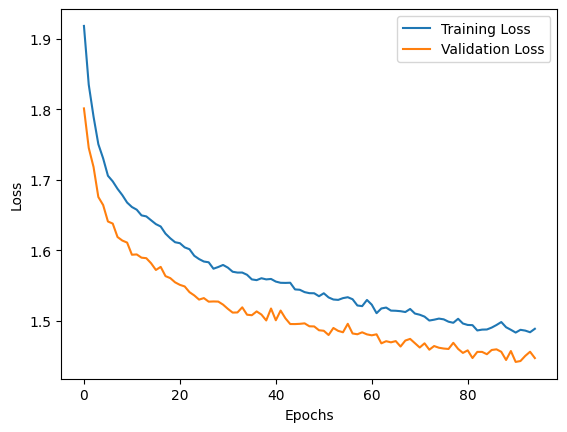

In [ ]:
 # "glove-twitter-25", "word2vec-google-news-300", "glove-wiki-gigaword-300", "fasttext-wiki-news-subwords-300"
print("Experiment C-1: embedding_type-glove-twitter-25")
_, train_loss, val_loss = train_evaluate(merge_operation='concat', embedding_type='glove-twitter-25', oov_handler="zero", freeze_emb=True,
                   model_layer_map=[512], lr_=lr, epochs_=epochs, batch_size_=batch_size, verbose_=False)
plot_loss_curve(train_loss[5:], val_loss[5:])

Experiment C-2: word2vec-google-news-300
Model with merge_operation = concat, embedding_type: word2vec-google-news-300, oov_handle: zero, freeze_emb: True, model_layer_map: [512], lr: 0.01, batch_size: 10000
Trainable paramaters:  466442
Percentage of unknown tokens: 5.64%
Percentage of unknown tokens: 5.66%
TextClassifier(
  (embedding): Embedding(3000002, 300)
  (fc_layers): ModuleList(
    (0): Linear(in_features=900, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_out): Linear(in_features=512, out_features=10, bias=True)
)
7.22, 12.19, 22.85, 41.02, 48.00, 53.77, 58.06, 61.01, 64.30, 66.81, 67.98, 69.36, 69.93, 70.16, 70.72, 70.99, 71.77, 72.03, 72.13, 72.30, 72.37, 72.73, 72.53, 72.99, 73.09, 72.84, 73.12, 73.29, 73.39, 73.32, 73.29, 73.46, 73.17, 73.68, 73.86, 73.93, 74.01, 74.17, 74.10, 74.06, 73.92, 74.35, 74.33, 74.39, 74.44, 74.46, 74.60, 74.64, 74.15, 74.28, 74.52, 74.68, 74.69, 74.61, 74.71, 74.93, 75.03, 75.07, 74.99, 74.90, 74.84, 74.84, 

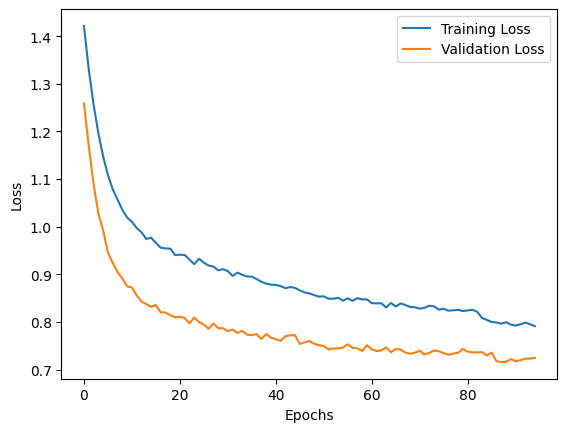

In [ ]:
print("Experiment C-2: word2vec-google-news-300")
_, train_loss, val_loss = train_evaluate(merge_operation='concat', embedding_type='word2vec-google-news-300', oov_handler="zero", freeze_emb=True,
                   model_layer_map=[512], lr_=lr, epochs_=epochs, batch_size_=batch_size, verbose_=False)
plot_loss_curve(train_loss[5:], val_loss[5:])

Experiment C-3: glove-wiki-gigaword-300
Model with merge_operation = concat, embedding_type: glove-wiki-gigaword-300, oov_handle: zero, freeze_emb: True, model_layer_map: [512], lr: 0.01, batch_size: 10000
Trainable paramaters:  466442
Percentage of unknown tokens: 3.21%
Percentage of unknown tokens: 3.23%
TextClassifier(
  (embedding): Embedding(400002, 300)
  (fc_layers): ModuleList(
    (0): Linear(in_features=900, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_out): Linear(in_features=512, out_features=10, bias=True)
)
12.54, 15.91, 18.33, 21.75, 32.75, 43.41, 46.79, 55.57, 59.46, 61.72, 63.90, 65.78, 66.93, 68.48, 69.97, 70.44, 70.92, 71.38, 71.85, 72.25, 72.43, 72.76, 72.98, 72.93, 73.35, 73.30, 73.64, 73.50, 73.73, 74.00, 74.00, 74.17, 74.42, 74.51, 74.58, 74.57, 74.81, 74.72, 74.63, 74.98, 74.85, 74.97, 75.07, 75.19, 75.26, 75.26, 75.28, 75.32, 75.55, 75.58, 75.55, 75.37, 75.33, 75.69, 75.77, 75.67, 75.65, 75.88, 75.91, 75.86, 75.60, 75.72, 75

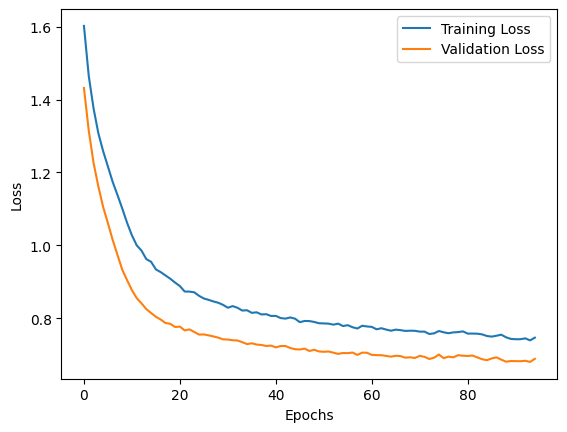

In [ ]:
print("Experiment C-3: glove-wiki-gigaword-300")
_, train_loss, val_loss = train_evaluate(merge_operation='concat', embedding_type='glove-wiki-gigaword-300', oov_handler="zero", freeze_emb=True,
                   model_layer_map=[512], lr_=lr, epochs_=epochs, batch_size_=batch_size, verbose_=False)
plot_loss_curve(train_loss[5:], val_loss[5:])

## D: Pretrained vs custom models

Experiment D-1:
Model with merge_operation = concat, embedding_type: custom_fasttext_100_5_5_10_1, oov_handle: zero, freeze_emb: True, model_layer_map: [256], lr: 0.01, batch_size: 10000
Trainable paramaters:  79626
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 100)
  (fc_layers): ModuleList(
    (0): Linear(in_features=300, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_out): Linear(in_features=256, out_features=10, bias=True)
)
9.61, 25.07, 29.74, 48.08, 63.26, 68.66, 71.37, 73.29, 73.99, 75.46, 76.02, 77.26, 77.60, 78.27, 78.48, 78.86, 78.94, 79.26, 79.57, 79.61, 79.47, 79.47, 79.99, 80.07, 80.00, 80.23, 80.33, 80.49, 80.52, 80.48, 80.82, 80.70, 80.80, 80.65, 80.73, 80.76, 80.77, 81.06, 80.82, 81.11, 81.00, 81.02, 81.14, 80.96, 81.00, 80.98, 80.82, 81.13, 81.22, 81.14, 81.10, 81.45, 81.21, 81.24, 81.49, 81.29, 81.50, 81.35, 81.51, 81.38, 81.25, 81.01, 81.03, 81.09, 81.58, 81

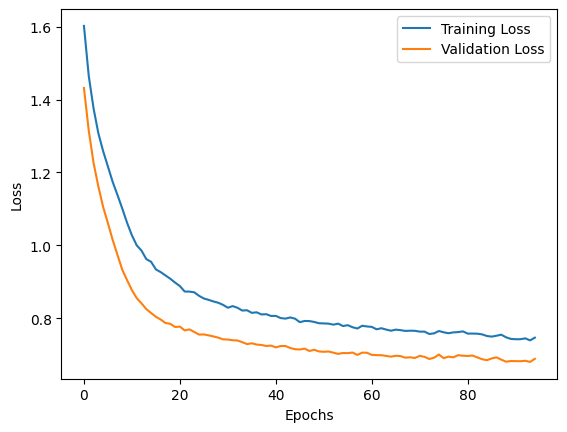

In [ ]:
print("Experiment D-1:")
_, train_loss_b, val_loss_b = train_evaluate(merge_operation='concat', embedding_type='custom_fasttext_100_5_5_10_1', oov_handler="zero", freeze_emb=True,
                   model_layer_map=[256], lr_=lr, epochs_=epochs, batch_size_=batch_size, verbose_=False)
plot_loss_curve(train_loss[5:], val_loss[5:])

## E: Frozen or finetune embeddings layer

Experiment E-1 Repeat: merge_operation-average
Model with merge_operation = concat, embedding_type: custom_word2vec_300_5_5_20_1, oov_handle: zero, freeze_emb: False, model_layer_map: [512], lr: 0.0001, batch_size: 10000
Trainable paramaters:  46259942
Percentage of unknown tokens: 0.20%
Percentage of unknown tokens: 0.20%
TextClassifier(
  (embedding): Embedding(152645, 300)
  (fc_layers): ModuleList(
    (0): Linear(in_features=900, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=512, out_features=10, bias=True)
)
33.35, 60.84, 69.37, 72.76, 74.92, 76.04, 76.94, 77.68, 78.17, 78.77, 79.01, 79.46, 79.66, 80.00, 80.39, 80.55, 80.90, 81.02, 81.25, 81.39, 81.52, 81.68, 81.85, 82.14, 82.10, 82.31, 82.44, 82.52, 82.71, 82.70, 82.83, 82.91, 82.99, 83.12, 83.22, 83.29, 83.39, 83.36, 83.54, 83.60, 83.61, 83.75, 83.76, 83.79, 83.89, 83.91, 84.00, 84.08, 84.03, 84.09, 84.18, 84.14, 84.26, 84.28, 84.30, 84.27, 84.31, 84.39, 84.48, 84.43,

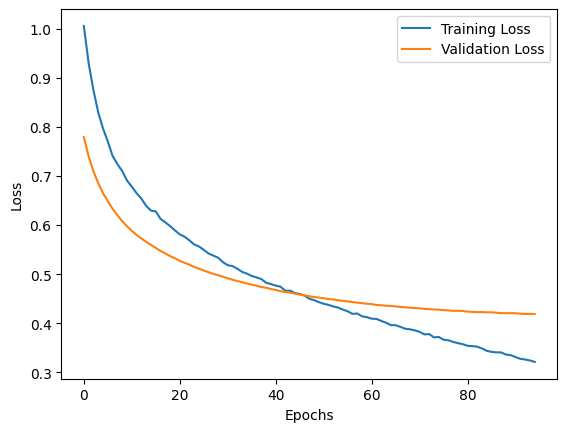

In [ ]:
print("Experiment E-1: finetune word embeddings layer")
modelE, train_loss, val_loss = train_evaluate(merge_operation='concat', embedding_type='custom_word2vec_300_5_5_20_1', oov_handler="zero", freeze_emb=False,
                   model_layer_map=[512], lr_=0.0001, epochs_=epochs, batch_size_=batch_size, verbose_=False)
plot_loss_curve(train_loss[5:], val_loss[5:])

In [ ]:
# torch.save(modelE.to('cpu'), "torch_demo.bin")